In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import asyncio
import os
from collections import defaultdict
from dataclasses import dataclass, field
from datetime import datetime
from typing import Literal

import pandas as pd
from dotenv import load_dotenv
from dspy import LM, ChainOfThought, InputField, OutputField, Signature, configure
from fastembed import TextEmbedding
from IPython.display import Markdown, display
from langchain.schema import Document
from langchain.tools import tool
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import CSVLoader
from langchain_community.vectorstores import FAISS
from langchain_core.embeddings import Embeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_deepseek import ChatDeepSeek
from langchain_experimental.text_splitter import SemanticChunker
from langchain_tavily import TavilySearch
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langsmith import traceable
from loguru import logger
from pydantic import BaseModel, Field

from source_formatter import SourceFormatter

In [ ]:
# Load environment variables
_ = load_dotenv()

# Initialize LLM
llm = ChatDeepSeek(model="deepseek-chat")

# Load and prepare the dataset
df = pd.read_csv("data/hiv_aids_prevalence_africa.csv")
df["Article"] = df["Title"].str.cat(df["Abstract"].fillna(""), sep=".\n ")
df.drop(columns=["Abstract"], inplace=True)
df.to_csv("data/tests.csv", index=False)

In [ ]:
@dataclass
class FastEmbed(Embeddings):
    fe: TextEmbedding = field(default_factory=TextEmbedding)

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        return [emb.tolist() for emb in self.fe.embed(texts)]

    def embed_query(self, text: str) -> list[float]:
        return list(self.fe.embed([text]))[0].tolist()

In [ ]:
df.columns

Index(['Pmid', 'Title', 'Authors', 'Journal', 'Keywords', 'Url',
       'Affiliations', 'Publication Date', 'References', 'Article'],
      dtype='object')

In [ ]:
embeddings = FastEmbed(
    TextEmbedding(
        model_name="BAAI/bge-small-en-v1.5",
        cache_dir=os.path.expanduser("~/.cache/fastembed"),
        local_files_only=True,
    )
)

splitter = SemanticChunker(embeddings)

loader = CSVLoader(
    file_path="data/tests.csv",
    source_column="Pmid",
    content_columns=["Article"],
    metadata_columns=[
        "Pmid",
        "Title",
        "Url",
        "Authors",
        "Keywords",
        "Journal",
        "Affiliations",
        "Publication Date",
        "References",
    ],
)

documents = loader.load()
splitted_documents = splitter.split_documents(documents)

In [ ]:
def batch_process(
    documents: list[Document],
    embeddings,
    persist_directory,
    batch_size=10,
):
    # Check if the persist directory exists
    if not os.path.exists(persist_directory):
        logger.warning(
            f"Persist directory {persist_directory} does not exist. Creating it"
        )
        os.makedirs(persist_directory, exist_ok=True)

    # Create the batches
    batch_docs = [
        documents[i : i + batch_size] for i in range(0, len(documents), batch_size)
    ]

    if os.path.exists(os.path.join(persist_directory, "index.faiss")):
        logger.info(
            f"Vector Index already exists. Loading it from {persist_directory}."
        )
        vector_index = FAISS.load_local(
            persist_directory,
            embeddings=embeddings,
            allow_dangerous_deserialization=True,
        )
    else:
        logger.info("Creating new FAISS index from documents")
        # Create the vector_store
        vector_index = FAISS.from_documents(batch_docs[0], embeddings)

        for batch in batch_docs[1:]:
            vector_index.add_documents(batch)

        # Persist the index
        vector_index.save_local(persist_directory)

    return vector_index

In [ ]:
embedding_model = FastEmbed(
    TextEmbedding(
        model_name="jinaai/jina-embeddings-v2-base-en",
        cache_dir=os.path.expanduser("~/.cache/fastembed"),
        local_files_only=True,
    )
)

In [ ]:
vector_store = batch_process(
    splitted_documents, embedding_model, persist_directory="../faiss_index"
)

2025-09-05 16:50:35.623 | INFO     | __main__:batch_process:20 - Vector Index already exists. Loading it from ../faiss_index.


In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

results = retriever.invoke(
    "What strategies are suggested to reduce HIV prevalence among dialysis patients worldwide?"
)

In [ ]:
class RetrieverReportGenerator:
    """Generates structured reports from retriever results."""

    def __init__(self, report_title: str = "Research Findings Report"):
        self.report_title = report_title

    def _process_retriever_results(self, results):
        grouped_docs = defaultdict(list)

        for i, result in enumerate(results, 1):
            title = result.metadata.get("Title", f"Document: {i}")
            url = result.metadata.get("Url", "No URL Available")
            doc_key = url if url != "No URL Available" else title

            grouped_docs[doc_key].append(
                {
                    "chunk_id": i,
                    "title": title,
                    "url": url,
                    "authors": result.metadata.get("Authors", ""),
                    "pub_date": result.metadata.get("Publication Date", ""),
                    "references": result.metadata.get("References", ""),
                    "content": result.page_content,
                }
            )

        return grouped_docs

    def _generate_summary_stats(self, grouped_docs):
        total_docs = len(grouped_docs)
        total_chunks = sum(len(chunks) for chunks in grouped_docs.values())
        multichunk_docs = [
            (doc_key, len(chunks))
            for doc_key, chunks in grouped_docs.items()
            if len(chunks) > 1
        ]

        return {
            "total_docs": total_docs,
            "total_chunks": total_chunks,
            "multichunk_docs": multichunk_docs,
        }

    def _generate_markdown_report(self, grouped_docs):
        markdown = (
            f"# {self.report_title}\n"
            f"*Generated on {datetime.now().strftime('%B %d, %Y at %I:%M %p')}*\n\n"
            f"**Summary:**\n"
            f"- Total unique documents: {len(grouped_docs)}\n"
            f"- Total chunks processed: {sum(len(chunks) for chunks in grouped_docs.values())}\n\n"
            "---\n\n"
        )

        for doc_num, (_, chunks) in enumerate(grouped_docs.items(), 1):
            first_chunk = chunks[0]
            markdown += (
                f"## {doc_num}. {first_chunk['title']}\n"
                f"**Authors:** {first_chunk['authors'] or 'Not Specified'}  \n"
                f"**Publication Date:** {first_chunk['pub_date'] or 'Not specified'}  \n"
                f"**URL:** {first_chunk['url']}  \n"
                f"**References:** {first_chunk['references'] or 'Not available'}  \n"
                f"**Chunks found:** {len(chunks)}\n\n"
                f"### Content:\n\n"
            )

            for chunk in chunks:
                if len(chunks) > 1:
                    markdown += f"**Chunk {chunk['chunk_id']}:**\n\n"
                markdown += f"{chunk['content']}\n\n"
                if len(chunks) > 1:
                    markdown += "---\n\n"

            markdown += "\n"

        return markdown

    def create_report(self, results):
        grouped_docs = self._process_retriever_results(results)
        stats = self._generate_summary_stats(grouped_docs)
        markdown_report = self._generate_markdown_report(grouped_docs)

        stats_section = (
            "## Report Statistics\n\n"
            f"- **Total Documents:** {stats['total_docs']}\n"
            f"- **Total Chunks:** {stats['total_chunks']}\n\n"
            "### Documents with Multiple Chunks:\n"
        )

        if stats["multichunk_docs"]:
            for doc_key, chunk_count in stats["multichunk_docs"]:
                display_key = doc_key[:60] + "..." if len(doc_key) > 60 else doc_key
                stats_section += f"- {display_key}: {chunk_count} chunks\n"
        else:
            stats_section += "- None (all documents had single chunks)\n"

        # Insert stats right after the summary
        markdown_report = markdown_report.replace("---\n", f"{stats_section}\n---\n", 1)

        return markdown_report, grouped_docs, stats

In [ ]:
report_gen = RetrieverReportGenerator("Results from Research")
markdown, grouped, stats = report_gen.create_report(results)

In [ ]:
display(Markdown(markdown))

# Results from Research
*Generated on September 05, 2025 at 04:51 PM*

**Summary:**
- Total unique documents: 8
- Total chunks processed: 10

## Report Statistics

- **Total Documents:** 8
- **Total Chunks:** 10

### Documents with Multiple Chunks:
- https://www.ncbi.nlm.nih.gov/pubmed/39979539: 2 chunks
- https://www.ncbi.nlm.nih.gov/pubmed/40795077: 2 chunks

---

## 1. Global epidemiology of HIV among dialysis patients: a systematic review and meta-analysis.
**Authors:** Khandker Shahad Saif, Jahan Safrin, Khan Adiba Ayesha, Abrittee Begum Faijunnesa, Nanjiba Rifah, Islam Dewan Zubaer, Suez Ehsan, Rahman Md Habibur, Farahim Farha, Ali Talat, Begum Rahima  
**Publication Date:** 2025-Jul  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/39979539  
**References:** Wang H, Wolock TM, Carter A et al (2016) Estimates of global, regional, and national incidence, prevalence, and mortality of HIV, 1980–2015: the Global Burden of Disease Study 2015. The lancet HIV 3:e361–e387 | Shabbir NA, Kant SB, Rashid K et al (2024) Prevalence of HIV/AIDS among pregnant women in North American region: A systematic review and meta-analysis. Medicine 103:e40339 https://pubmed.ncbi.nlm.nih.gov/39496052 | THE GLOBAL HEALTH OBSERVATORY. (2023). https://www.who.int/data/gho/data/themes/hiv-aids#:~:text=Global%20situation%20and%20trends%3A&text=Globally%2C%2039.0%20million%20%5B33.1%E2%80%93,considerably%20between%20countries%20and%20regions . Accessed: 20 Nov 2023 | Simon V, Ho DD, Karim QA (2006) HIV/AIDS epidemiology, pathogenesis, prevention, and treatment. The Lancet 368:489–504 | Cummins NW, Badley AD (2015) Can HIV be cured and should we try? In Mayo Clinic Proceed 90:705–709  
**Chunks found:** 2

### Content:

**Chunk 1:**

15 studies matched our eligibility criteria and were included in the study. The worldwide pooled prevalence of HIV among dialysis patients was 0.8% (95% CI 0.4 to 1.2) with a high degree of heterogeneity (95%) among the included studies. Substantial variations in pooled prevalence were found among different continents in our subgroup analysis. Africa (21.1%, 95% CI 6.4 to 35.8) and North America (19.3%, 95% CI 0.0 to 39.8) had a higher prevalence of HIV in dialysis patients whereas in Europe (0.3%, 95% CI 0.0 to 0.6), South America (0.7%, 95% CI 0.0 to 1.6) and Asia (0.7%, 95% CI 0.0 to 1.6) the frequency was much lower. Perhaps, due to the lack of awareness and preventive knowledge, insufficient healthcare facilities and breaches in infection control protocols in dialysis centers, risky attitudes and practices immigration issues the prevalence of HIV among dialysis patients in Africa and North America enhanced as compared to that of Europe, Asia and South America. Strict adherence to HIV preventive practices, raising public awareness, and advanced healthcare systems are suggested to reduce the prevalence of HIV among dialysis patients all over the world.

---

**Chunk 2:**

Article: Global epidemiology of HIV among dialysis patients: a systematic review and meta-analysis.. HIV transmission and infection among dialysis patients have become a major healthcare concern and a rising threat throughout the world. Our current systematic review and meta-analysis targeted to determine the global epidemiologic state of HIV infection among dialysis patients. Three online databases: Google Scholar, PubMed, and ScienceDirect were searched for eligible studies using specific keywords.

---


## 2. Preventing HIV in women in Africa.
**Authors:** Cowan Frances M, Shahmanesh Maryam, Revill Paul A, Busza Joanna, Sibanda Euphemia L, Chabata Sungai T, Chimbindi Natsayi, Choola Tamara, Mugurungi Owen, Hargreaves James R, Phillips Andrew N  
**Publication Date:** 2025-Mar  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/39948405  
**References:** UNAIDS. 2024 global AIDS report — The Urgency of Now: AIDS at a Crossroads https://www.unaids.org/en/resources/documents/2024/global-aids-update-2024 (2024). | UNAIDS. West and Central Africa regional profile — 2024 global AIDS update The Urgency of Now: AIDS at a Crossroads https://www.unaids.org/en/resources/documents/2024/2024-unaids-global-aids-update-western-central-africa (2024). | UNAIDS. Eastern and Southern Africa regional profile — 2024 global AIDS update The Urgency of Now: AIDS at a Crossroads https://www.unaids.org/en/resources/documents/2024/2024-unaids-global-aids-update-eastern-southern-africa (2024). | UNAIDS. The path that ends AIDS: UNAIDS Global AIDS Update https://www.unaids.org/en/resources/documents/2023/global-aids-update-2023 (2023). | Canning, D., Raja, S. & Yazbeck, A. Africa’s demographic transition: dividend or disaster? https://documents.worldbank.org/en/publication/documents-reports/documentdetail/802811468187135148/africa-s-demographic-transition-dividend-or-disaster (World Bank Group, 2015).  
**Chunks found:** 1

### Content:

Article: Preventing HIV in women in Africa.. HIV incidence is declining globally, but around half of all new infections are in sub-Saharan Africa-where adolescent girls and young women bear a disproportionate burden of new infections. Those who sell sex are at particularly high risk. Despite declining incidence rates and availability of effective biomedical prevention tools, we are not on track, globally or in Africa, to achieve UNAIDS 2025 prevention targets.


## 3. Age and gender profiles of HIV infection burden and viraemia: novel metrics for HIV epidemic control in African populations with high antiretroviral therapy coverage.
**Authors:** Brizzi Andrea, Kagaayi Joseph, Ssekubugu Robert, Abeler-Dörner Lucie, Blenkinsop Alexandra, Bonsall David, Chang Larry W, Fraser Christophe, Galiwango Ronald M, Kigozi Godfrey, Kyle Imogen, Monod Mélodie, Nakigozi Gertrude, Nalugoda Fred, Rosen Joseph G, Laeyendecker Oliver, Quinn Thomas C, Grabowski M Kate, Reynolds Steven J, Ratmann Oliver  
**Publication Date:** 2025-Jun-11  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/40795077  
**References:** UNAIDS. <i>The Path that Ends AIDS: UNAIDS Global AIDS Update 2023</i>. 2023. https://www.unaids.org/en/resources/documents/2023/global-aids-update-2023 (18 July 2023, date last accessed). | Mills EJ, Bakanda C, Birungi J  et al.  Life expectancy of persons receiving combination antiretroviral therapy in low-income countries: A cohort analysis from Uganda. Ann Intern Med  2011;155:209–16. https://pubmed.ncbi.nlm.nih.gov/21768555 | Herbst AJ, Cooke GS, Bärnighausen T, KanyKany A, Tanser F, Newell M.  Adult mortality and antiretroviral treatment roll-out in rural KwaZulu-Natal, South Africa. Bull World Health Org  2009;87:754–62. https://pubmed.ncbi.nlm.nih.gov/19876542 | Reniers G, Slaymaker E, Nakiyingi-Miiro J  et al. ; ALPHA Network. Mortality trends in the era of antiretroviral therapy: evidence from the Network for Analysing Longitudinal Population based HIV/AIDS data on Africa (ALPHA). AIDS  2014;28 Suppl 4:S533–42. Nov https://pubmed.ncbi.nlm.nih.gov/25406756 | Attia S, Egger M, Müller M, Zwahlen M, Low N.  Sexual transmission of HIV according to viral load and antiretroviral therapy: systematic review and meta-analysis. AIDS  2009;23:1397–404. https://pubmed.ncbi.nlm.nih.gov/19381076  
**Chunks found:** 2

### Content:

**Chunk 4:**

Article: Age and gender profiles of HIV infection burden and viraemia: novel metrics for HIV epidemic control in African populations with high antiretroviral therapy coverage.. To prioritize and tailor interventions for ending AIDS by 2030 in Africa, it is important to characterize the population groups in which human immunodeficiency virus (HIV) viraemia is concentrating. We analysed HIV testing and viral load data collected between 2013 and 2019 from the open, population-based Rakai Community Cohort Study in Uganda, to estimate HIV seroprevalence and population viral suppression over time by gender, 1-year age bands, and residence in inland and fishing communities. All estimates were standardized to the underlying source population by using census data.

---

**Chunk 5:**

We then assessed 95-95-95 targets in their ability to identify the populations in which viraemia is concentrated. Following the implementation of Universal Test and Treat, the proportion of individuals with viraemia decreased from 4.9% (4.6%-5.3%) in 2013 to 1.9% (1.7%-2.2%) in 2019 in inland communities and from 19.1% (18.0%-20.4%) in 2013 to 4.7% (4.0%-5.5%) in 2019 in fishing communities. Viraemia did not concentrate in the age and gender groups furthest from achieving 95-95-95 targets. Instead, in both inland and fishing communities, women aged 25-29 years and men aged 30-34 years were the 5-year age groups that contributed most to population-level viraemia in 2019, despite these groups being close to or having already achieved 95-95-95 targets. The 95-95-95 targets provide a useful benchmark for monitoring progress towards HIV epidemic control, but do not contextualize underlying population structures and so may direct interventions towards groups that represent a marginal fraction of the population with viraemia.

---


## 4. Potential impact and cost-effectiveness of long-acting injectable lenacapavir plus cabotegravir as HIV treatment in Africa.
**Authors:** Phillips Andrew, Smith Jennifer, Bansi-Matharu Loveleen, Sikwese Kenly, Kityo Cissy, Flexner Charles, Vitoria Marco, Ford Nathan, Doherty Meg, Panos Zack, Ripin David, Hickey Matthew, Havlir Diane, Gandhi Monica, Reid Michael, Revill Paul  
**Publication Date:** 2025-Jul-01  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/40593655  
**References:** UNAIDS. <i>2024 Gobal AIDS Report — The Urgency of Now: AIDS at a Crossroads</i>. https://www.unaids.org/en/resources/documents/2024/global-aids-update-2024 (2024). | Rodger, A. J. et al. Sexual activity without condoms and risk of HIV transmission in sero-different couples when the HIV-positive partner is using suppressive antiretroviral therapy. <i>JAMA</i><b>316</b>, 171–181 (2016). https://pubmed.ncbi.nlm.nih.gov/27404185 | Nachega, J. B. et al. Long-acting antiretrovirals and HIV treatment adherence. <i> Lancet HIV</i><b>10</b>, e332–e342 (2023). https://pubmed.ncbi.nlm.nih.gov/37062293 | Toska, E. et al. Factors associated with preferences for long-acting injectable antiretroviral therapy among adolescents and young people living with HIV in South Africa. <i>AIDS Behav.</i><b>27</b>, 2163–2175 (2023). https://pubmed.ncbi.nlm.nih.gov/36622486 | Murray, M. et al. Identifying appropriate candidates for long-acting antiretroviral therapy: findings from a survey of health care providers in the ATLAS-2M trial. <i>HIV Res. Clin. Pract.</i><b>21</b>, 105–113 (2020). https://pubmed.ncbi.nlm.nih.gov/33048662  
**Chunks found:** 1

### Content:

Article: Potential impact and cost-effectiveness of long-acting injectable lenacapavir plus cabotegravir as HIV treatment in Africa.. Although viral suppression is attained for most adults living with diagnosed HIV in East, Central, Southern and West Africa (ECSWA), challenges remain with sustained adherence to daily oral pill taking for some in the population. Here, we evaluate the potential effectiveness and cost-effectiveness of introduction of a new combination of long-acting injectable drugs of lenacapavir + cabotegravir to increase levels of sustained viral suppression.


## 5. Interventions Integrating Mental Health Services Into HIV Care in Africa; a Scoping Review.
**Authors:** Nwogwugwu Charlotte, Favor Chinedum, Fu Yunting, Iheanacho Theddeus  
**Publication Date:** 2025  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/40692722  
**References:** Adeoti AO, Dada M, Elebiyo T, Fadare J, Ojo O. Survey of Antiretroviral Therapy Adherence and Predictors of Poor Adherence Among HIV Patients in a Tertiary Institution in Nigeria. Pan Afr Med J (2019) 33:277. 10.11604/pamj.2019.33.277.18711 https://pubmed.ncbi.nlm.nih.gov/31692880 | Kayiteshonga Y, Sezibera V, Mugabo L, Nsabimana E. Prevalence of Mental Disorders, Associated Co-morbidities, Health Care Knowledge and Service Utilization in Rwanda – towards a Blueprint for Promoting Mental Health Care Services in Low- and Middle-Income Countries? BMC Public Health (2022) 22:1858. 10.1186/s12889-022-14165-x https://pubmed.ncbi.nlm.nih.gov/36199102 | Bernard C, Dabis F, de Rekeneire N. Prevalence and Factors Associated with Depression in People Living with HIV in Sub-saharan Africa: A Systematic Review and Meta-Analysis. PLoS ONE (2017) 12(8):e0181960. 10.1371/journal.pone.0181960 https://pubmed.ncbi.nlm.nih.gov/28783739 | Cai Z, Chang Q, Yip PS. A Scientometric Analysis of Suicide Research: 1990–2018. J Affective Disord (2020) 266:356–65. 10.1016/j.jad.2020.01.121 https://pubmed.ncbi.nlm.nih.gov/32056899 | Ciesla JA, Roberts JE. Meta‐analysis of the Relationship between HIV Infection and Risk for Depressive Disorders. Am J Psychiatry (2001) 158(5):725–30. 10.1176/appi.ajp.158.5.725 https://pubmed.ncbi.nlm.nih.gov/11329393  
**Chunks found:** 1

### Content:

Of 818 studies identified, 16 from six African countries met inclusion criteria, with Zimbabwe and South Africa leading in interventions. Most targeted depression, employing non-pharmacological approaches such as task-sharing and stepped-care models. Findings suggest integrated MH and HIV care improves MH symptoms and adherence to antiretroviral therapy. Despite limited studies, evidence supports the feasibility and benefits of integrating MH services into HIV care in Africa. Scaling evidence-based interventions is essential to address unmet MH needs in this population.


## 6. Understanding stigma as a barrier to cancer prevention and treatment: a qualitative study among people living with HIV in Uganda and Zambia.
**Authors:** Guy Kyra, Arinaitwe Jim, Goma Fastone Mathew, Atuyambe Lynn, Guwatudde David, Zyambo Cosmas, Kusolo Ronald, Mukupa Musawa, Musasizi Ezekiel, Wipfli Heather  
**Publication Date:** 2025-Mar-12  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/40074264  
**References:** McGettrick P, Barco EA, Mallon PWG. Healthcare (Basel, Switzerland) Ageing with HIV. 2018;17 doi: 10.3390/healthcare6010017. https://pubmed.ncbi.nlm.nih.gov/29443936 | Moyo E, Moyo P, Murewanhema G, et al. Key populations and Sub-Saharan Africa’s HIV response. Front Public Health. 2023;11:1079990. doi: 10.3389/fpubh.2023.1079990. https://pubmed.ncbi.nlm.nih.gov/37261232 | Corrigan KL, Wall KC, Bartlett JA, et al. Cancer disparities in people with HIV: A systematic review of screening for non-AIDS-defining malignancies. Cancer. 2019;125:843–53. doi: 10.1002/cncr.31838. https://pubmed.ncbi.nlm.nih.gov/30645766 | Rodés B, Cadiñanos J, Esteban-Cantos A, et al. Ageing with HIV: Challenges and biomarkers. EBioMedicine. 2022;77:103896. doi: 10.1016/j.ebiom.2022.103896. https://pubmed.ncbi.nlm.nih.gov/35228014 | Mathoma A, Sartorius B, Mahomed S. The Trends and Risk Factors of AIDS-Defining Cancers and Non-AIDS-Defining Cancers in Adults Living with and without HIV: A Narrative Review. J Cancer Epidemiol . 2024;2024:7588928. doi: 10.1155/2024/7588928. https://pubmed.ncbi.nlm.nih.gov/38549952  
**Chunks found:** 1

### Content:

Data were collected from two districts of Uganda and Zambia. In Uganda, the two selected districts were Arua, in the northern West Nile region, and Moroto, in the northeast Karamoja region. In Zambia, the study districts were Mongu, in the Western Province, and Chipata in the Eastern Province. Each study district held two PLWH focus groups (one male, another female) with 5-7 participants per group and 3-4 key informant interviews for a total of 55 participants. PLWH and healthcare providers were eligible if they were (1) aged 18 years or older and (2) an HIV-positive client receiving antiretroviral therapy services at the participating clinic or working in a health services capacity at the clinic. Cancer stigma drivers included widespread misconceptions about disease origins and outcomes, associations with other stigmatising conditions and behaviours such as HIV, TB, and substance use, limited treatment options that heightened fears of diagnosis and inadequate training of healthcare providers. Study participants noted that experiences of stigma led to reduced treatment-seeking behaviours among PLWH, increased social isolation, and poor cancer-related care practices within clinics. Recommended interventions to combat stigma included improved education for providers and patients, private counselling, and peer support. Results underscore the presence and impacts of stigma in the study population, emphasising the need for research informing culturally sensitive interventions that enhance educational outreach and promote engagement in care among targeted populations. This article is linked to an ongoing clinical trial registered on clinical trials.gov (clinical trial No: NCT05487807; Registration date: 27 November 2023) and relates to the pre-results stage.


## 7. HIV cure research contributions from Africa in the last three decades.
**Authors:** Nakanjako Damalie, Kankaka Edward N, Lungu Cynthia, Galiwango Ronald M, Reynolds Steven J, Mahmoudi Tokameh, Ndung'u Thumbi  
**Publication Date:** 2025  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/40861434  
**References:** UNAIDS . Fact Sheet 2024: Global HIV statistics. (2024). Available online at: https://www.unaids.org/sites/default/files/media_asset/UNAIDS_FactSheet_en.pdf. | Joussef-Pina S, Nankya I, Nalukwago S, Baseke J, Rwambuya S, Winner D, et al. Reduced and highly diverse peripheral HIV-1 reservoir in virally suppressed patients infected with non-B HIV-1 strains in Uganda. Retrovirology. (2022) 19:1. doi:  10.1186/s12977-022-00587-3, PMID: https://pubmed.ncbi.nlm.nih.gov/35033105 | Messele T, Abdulkadir M, Fontanet AL, Petros B, Hamann D, Koot M, et al. Reduced naive and increased activated CD4 and CD8 cells in healthy adult Ethiopians compared with their Dutch counterparts. Clin Exp Immunol. (1999) 115:443–50. doi:  10.1046/j.1365-2249.1999.00815.x, PMID: https://pubmed.ncbi.nlm.nih.gov/10193416 | Nedelec Y, Sanz J, Baharian G, Szpiech ZA, Pacis A, Dumaine A, et al. Genetic ancestry and natural selection drive population differences in immune responses to pathogens. Cell. (2016) 167:657–69:e21. doi:  10.1016/j.cell.2016.09.025, PMID: https://pubmed.ncbi.nlm.nih.gov/27768889 | Rizzardini G, Piconi S, Ruzzante S, Fusi ML, Lukwiya M, Declich S, et al. Immunological activation markers in the serum of African and European HIV-seropositive and seronegative individuals. AIDS. (1996) 10:1535–42. doi:  10.1097/00002030-199611000-00012, PMID: https://pubmed.ncbi.nlm.nih.gov/8931789  
**Chunks found:** 1

### Content:

This was repeated using loop functions until we obtained all articles directly or indirectly linked to the original paper. Overall, we show an increasing trend of HIV cure-related observational and interventional studies globally; with the least number of studies in Africa. The PubMed query retrieved 7122 HIV cure-related published articles, as at 23 July 2024; of which 2820 were directly or indirectly linked to understanding the HIV reservoir. Of the 2916 articles with first author affiliation country determined, only 52 (0.02%) had affiliations from African institutions. Of the 1955 articles with last author affiliation country determined, only 43 (0.02%) had affiliations from institutions in Africa. The majority of articles with first or last authors from African institutes were descriptive clinical studies of HIV infection, with less than ten studies specifically addressing HIV latency. Scale up of HIV cure research in Africa remains critical to hasten achievement of the global goal of an end to the AIDS epidemic by 2030. There is a need to bridge the technical, infrastructural and technological divides and address constraints in funding and capacity; to promote discovery, characterization and application of promising innovative therapies including immunotherapies and cell and gene therapies towards attaining an effective, durable, affordable and scalable HIV cure.


## 8. Impact of scaling up harm reduction interventions on injecting risk behaviours, ART outcomes and HIV incidence among people who inject drugs in Kenya.
**Authors:** Walker Josephine G, Akiyama Matthew J, Artenie Adelina, Cleland Charles M, Lizcano John A, Musyoki Helgar, Nyakowa Mercy, Cherutich Peter, Kurth Ann E, Vickerman Peter  
**Publication Date:** 2025-Jun  
**URL:** https://www.ncbi.nlm.nih.gov/pubmed/40328143  
**References:** Not available  
**Chunks found:** 1

### Content:

Over the rounds, coverage increased from zero to 80-86 % for NSP and zero to 10-20 % for OAT. The proportion of people living with HIV (PLHIV) that were virally suppressed increased from 7-14 % to 39-55 %. Accessing NSP and OAT was associated with reduced syringe sharing at last injection (NSP adjusted odds ratio (aOR)=0.31; 95 %CI:0.24-0.40; OAT aOR=0.046; 95 %CI:0.034-0.061) and OAT was associated with reduced injecting frequency (adjusted rate ratio=0.21; 95 %CI:0.12-0.36). Using OAT was associated with increased ART coverage (aOR=2.76; 95 %CI:1.50-5.06) and viral suppression (aOR=2.99; 95 %CI:1.78-5.03) among PLHIV, while NSP was not. HIV incidence decreased from 6.10 (95 %CI:3.56-9.77) to 1.49 (95 %CI:0.79-2.54) per 100 person-years between the first and second half of the study. Accessing NSP was associated with lower HIV incidence (adjusted hazard ratio=0.25; 95 %CI:0.087-0.58). This study provides strong evidence for the benefits of NSP and OAT on varied HIV outcomes among PWID in Africa.




In [ ]:
class StructuredOutput(BaseModel):
    answer: list[str] = Field(description="A List of search queries")


dspy_lm = LM(
    "deepseek/deepseek-chat",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com",
)
configure(lm=dspy_lm)


class MultiQueryGenerator(Signature):
    """Generate multiple research queries from a single user query."""

    question = InputField(desc="Original user query")
    num_queries = InputField(desc="Number of research queries to generate")
    research_queries: StructuredOutput = OutputField(
        desc="Generate a list of search terms to for the questions to aid in web search for an AI agent"
    )


query_optimizer = ChainOfThought(MultiQueryGenerator)


@traceable(name="query_generator")
def query_generator(question: str, num_queries: int):
    try:
        return query_optimizer(
            question=question, num_queries=num_queries
        ).research_queries.answer
    except Exception as e:
        print(f"An error occurred during query generation: {e}")
        return []

In [ ]:
queries = query_generator(
    "What role can generative AI play in designing novel CAR constructs targeting solid tumors?",
    5,
)

In [ ]:
queries

['generative AI design CAR constructs solid tumors',
 'deep learning optimize CAR-T cell therapy for solid cancers',
 'AI-generated novel CAR antigens targeting tumor microenvironment',
 'reinforcement learning in CAR construct engineering for solid malignancies',
 'generative adversarial networks (GANs) for predicting CAR-T efficacy in solid tumors']

In [ ]:
async def tavily_search_async(
    search_queries: list[str],
    max_results: int = 5,
    include_raw_content: bool = False,
    topic: Literal["general", "news", "finance"] = "general",
):
    tavily_search = TavilySearch(
        max_results=max_results, include_raw_content=include_raw_content, topic=topic
    )
    tasks = [tavily_search.ainvoke({"query": q}) for q in search_queries]
    results = await asyncio.gather(*tasks)
    return results

In [ ]:
retriever_tool = create_retriever_tool(
    retriever,
    "medical_paper_retriever",
    "Retrieves relevant medical research papers and their metadata (e.g., title, abstract, references) to support evidence-based answers.",
)
# tavily_tool = TavilySearch(max_results=2, topic="general")
search_response = await tavily_search_async(
    queries, max_results=5, include_raw_content=True
)

In [ ]:
formatter = SourceFormatter(
    markdown_output=False
)  # TODO: Implement the same formatting for the pubmed data as well
print(formatter.deduplicate_and_format_sources(search_response))

2025-09-04 12:41:19.056 | INFO     | source_formatter:deduplicate_and_format_sources:124 - Processing sources for deduplication and formatting
2025-09-04 12:41:19.061 | INFO     | source_formatter:deduplicate_and_format_sources:134 - Found 25 unique sources


Sources:

Source 1: More Effective Bi-Specific CAR T Cells Developed Using AI

URL: https://www.insideprecisionmedicine.com/topics/oncology/more-effective-bi-specific-car-t-cells-developed-using-ai/

Most relevant content: A research team at St. Jude Children’s Research Hospital has leveraged AI to use a computational approach to design more effective bi-specific chimeric antigen receptor (CAR) T cells. “We have developed and validated a computational tool that can significantly accelerate the design of tandem CAR constructs with improved surface expression and anti-tumor function,” said senior author Giedre Krenciute, PhD, a member of the department of bone marrow transplantation and cellular therapy (BMTCT) at St. Jude. The researchers said that the need for more computational tools and AI-driven design optimization will become more necessary that as treatments progress toward more complex synthetic proteins, such as bi-specific CARs, TRuCs, and synthetic cytokine receptors.

Full so

In [ ]:
@tool
async def web_search(search_queries: list[str]):
    """
    Search the web for the given search queries.
    """
    search_response = await tavily_search_async(
        search_queries, max_results=5, include_raw_content=True
    )

    deduplicated_response = formatter.deduplicate_and_format_sources(search_response)
    return deduplicated_response

In [ ]:
tools = [retriever_tool, web_search]  # TODO: Add the web search tool

llm_with_tools = llm.bind_tools(tools)

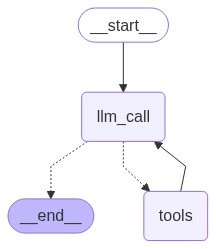

In [ ]:
rag_prompt = """
You are a helpful medical research assistant tasked with retrieving information from PubMed articles. 
Always clarify the user's research question or scope before retrieving. 
Use the retrieval tool to gather relevant PubMed abstracts, metadata, and references. 
Reflect on the retrieved context, prioritize citing references, and synthesize findings into accurate, evidence-based responses. 
If more context is needed, continue retrieving until you have sufficient coverage to answer the user's request thoroughly.
"""


class State(MessagesState):
    texts: str


def llm_call(state: State):
    messages = state.get("messages", [])

    # If no messages yet, start the conversation
    if not messages:
        messages = [
            SystemMessage(content=rag_prompt),
            HumanMessage(content=state["texts"]),
        ]

    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]}


# state = State(texts="What are the approaches to Task Decomposition?")
graph = StateGraph(State)
graph.add_node("llm_call", llm_call)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("llm_call")
graph.add_conditional_edges(
    "llm_call", tools_condition, {"tools": "tools", "__end__": END}
)
graph.add_edge("tools", "llm_call")

full_graph = graph.compile()
full_graph

In [ ]:
state = State(texts="What are the applications of AI in medicine according to PubMed?")
result = full_graph.invoke(state)

print(result["messages"][-1].content)  # Final assistant answer

Based on my search of PubMed literature, here's a comprehensive overview of the applications of artificial intelligence in medicine:

## Major Applications of AI in Medicine According to PubMed Research

### 1. **Medical Imaging and Diagnostics**
- **Radiology**: AI algorithms significantly improve accuracy and efficiency in interpreting X-rays, CT scans, and MRIs
- **Pathology**: Automated analysis of tissue samples and digital pathology images
- **Cardiology**: Coronary calcium scoring and early detection of cardiovascular abnormalities
- **Breast Cancer Screening**: Enhanced detection in mammography, ultrasound, and MRI
- **Ophthalmology**: Retinal image analysis for early eye disease detection
- **Nuclear Medicine**: AI-assisted image generation and interpretation

### 2. **Clinical Decision Support Systems**
- **Diagnostic Assistance**: AI tools that help physicians interpret complex medical data
- **Treatment Planning**: Personalized treatment recommendations based on patient dat